# Lokta-Volterra

In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Turing
using DifferentialEquations
using LinearAlgebra
using PyPlot

# Set a seed for reproducibility.
using Random
Random.seed!(14)

using Revise
using MicroCanonicalHMC

[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
[ Info: Precompiling DiffEqBaseTrackerExt [1ba67e42-7aa7-5162-ac9b-c09642cdebbf]
[ Info: Precompiling TuringOptimExt [cd2420fc-8d31-5c39-8d98-0365cfcf7d6e]
[ Info: Precompiling LinearSolveKernelAbstractionsExt [385e4588-a1a0-5c1d-98fa-d45bf6f8ecf9]
[ Info: Precompiling SimpleNonlinearSolveNNlibExt [dcf88060-b6e0-56c3-a9f7-6c117a3cde9e]
[ Info: Precompiling AdvancedHMCOrdinaryDiffEqExt [b79d61f8-5e13-53f1-8c3e-d7d191782ea7]
[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


# PDE-Modelling

In [3]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p);

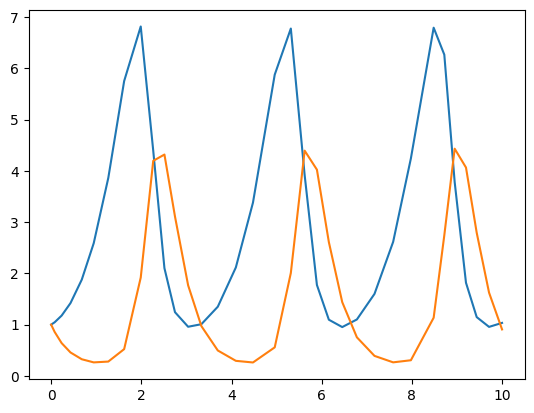

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1dc5e3c490>

In [4]:
sol = solve(prob, Tsit5())
u_1 = [u[1] for u in sol.u]
u_2 = [u[2] for u in sol.u]
plt.plot(sol.t, u_1)
plt.plot(sol.t, u_2)

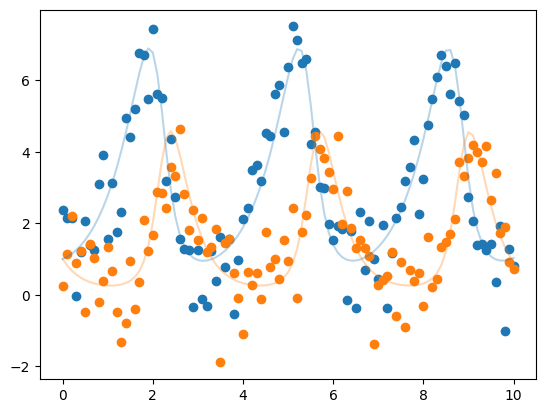

PyObject <matplotlib.collections.PathCollection object at 0x7f1dc5c14df0>

In [5]:
sol = solve(prob, Tsit5(); saveat=0.1)
u_1 = [u[1] for u in sol.u]
u_2 = [u[2] for u in sol.u]
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))
odedata[1, :]
# Plot simulation and noisy observations.
plt.plot(sol.t, u_1; alpha=0.3)
plt.plot(sol.t, u_2; alpha=0.3)
plt.scatter(sol.t, odedata[1, :]; label="")
plt.scatter(sol.t, odedata[2, :]; label="")

In [6]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(odedata, prob);

## MCHMC

In [15]:
spl = MCHMC(10_000, 0.01; sigma=ones(5), adaptive=true)
espl = externalsampler(spl)

Turing.Inference.ExternalSampler{MicroCanonicalHMC.MCHMCSampler}(MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(10000, 0.01, 1, true, "LF", nothing, nothing, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0, 1.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog))

In [16]:
samples = sample(model, espl, 100_000);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03[ Info: eps: 0.02221929201843121
[ Info: L: 0.0032462949783420366
[ Info: nu: 209.36321889853735
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


In [23]:
samples.value.data[:, 1]

100000-element Vector{Float64}:
 0.7905649102279874
 0.7917562109287563
 0.7936837263589064
 0.8072939501397982
 0.8144249574533853
 0.8070612005735965
 0.8183652575821593
 0.832713557547385
 0.830942314374576
 0.8355247372131617
 0.8312116073491324
 0.8314333965759846
 0.8348100155082628
 ⋮
 0.7895783297890543
 0.7887998271686205
 0.7893290117284404
 0.792784357484988
 0.7857452097951907
 0.775615796266454
 0.7672206431799354
 0.773882327264039
 0.7742401095773231
 0.7768750374608866
 0.7752267749764918
 0.7804916260794591

In [24]:
σ_mchmc = samples.value.data[:, 1]
α_mchmc = samples.value.data[:, 2]
β_mchmc = samples.value.data[:, 3]  
γ_mchmc = samples.value.data[:, 4]
δ_mchmc = samples.value.data[:, 5];

In [26]:
ESSs, rhat = Summarize(samples.value.data)
ESS = mean(ESSs)

1212.5411560930409

## NUTS

In [30]:
# Sample 3 independent chains with forward-mode automatic differentiation (the default).
samples_hmc = sample(model, NUTS(0.65), 50000; progress=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:10


Chains MCMC chain (50000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:51000
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 432.96 seconds
Compute duration  = 432.96 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           σ    0.8226    0.0414    0.0003   27176.3585   25919.8684    1.0000 ⋯
           α    1.5640    0.0596    0.0006   11404.5037   15508.7155    1.0000 ⋯
           β    1.1098    0.0582    0.0005   14820.7072   19555.2534    1.0000 ⋯
           γ    2.8084    0.1500    0.0014   11946.8594   16097.4606    1.0001 ⋯
           δ    0.9502    0.0548    0.0005   11658.65

In [31]:
σ_hmc = vec(samples_hmc["σ"])
α_hmc = vec(samples_hmc["α"])
β_hmc = vec(samples_hmc["β"]) 
γ_hmc = vec(samples_hmc["γ"])
δ_hmc = vec(samples_hmc["δ"]);

## Comp

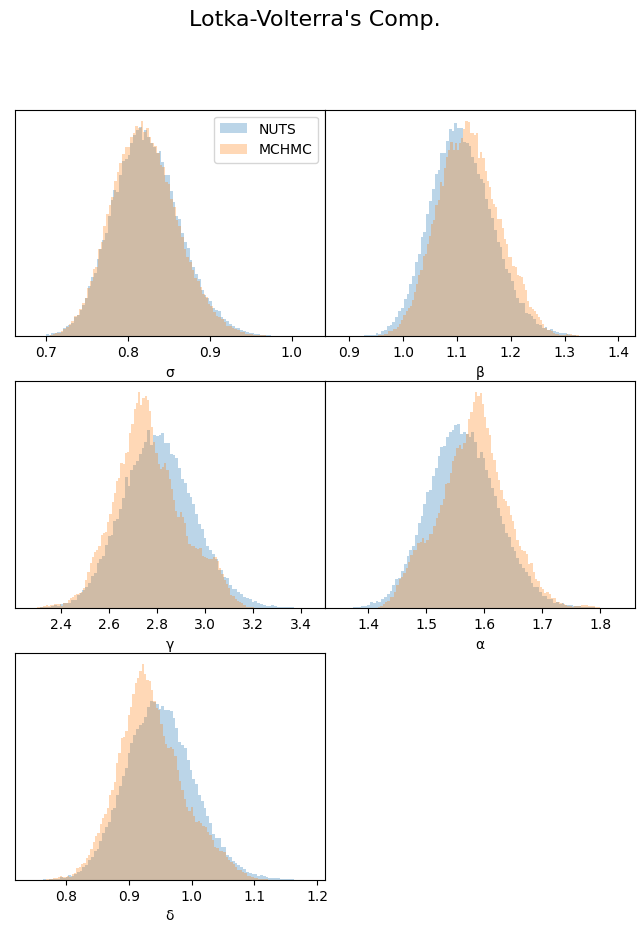

(0.0, 1.0, 0.0, 1.0)

In [32]:
fig, axis = plt.subplots(3, 2, figsize=(8,10))
fig.suptitle("Lotka-Volterra's Comp.", fontsize=16)

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(σ_hmc, bins=100, density=true, alpha = 0.3, label="NUTS")
axis[1,1].hist(σ_mchmc, bins=100, density=true, alpha = 0.3, label="MCHMC")
axis[1,1].legend()
axis[1,1].set_xlabel("σ")
axis[1,1].set_yticks([])

axis[1,2].hist(β_hmc, bins=100, density=true, alpha = 0.3)
axis[1,2].hist(β_mchmc, bins=100, density=true, alpha = 0.3)
axis[1,2].set_xlabel("β")
axis[1,2].set_yticks([])

axis[2,1].hist(γ_hmc, bins=100, density=true, alpha = 0.3)
axis[2,1].hist(γ_mchmc, bins=100, density=true, alpha = 0.3)
axis[2,1].set_xlabel("γ")
axis[2,1].set_yticks([])

axis[2,2].hist(α_hmc, bins=100, density=true, alpha = 0.3)
axis[2,2].hist(α_mchmc, bins=100, density=true, alpha = 0.3)
axis[2,2].set_xlabel("α")
axis[2,2].set_yticks([])

axis[3,1].hist(δ_hmc, bins=100, density=true, alpha = 0.3)
axis[3,1].hist(δ_mchmc, bins=100, density=true, alpha = 0.3)
axis[3,1].set_xlabel("δ")
axis[3,1].set_yticks([])

axis[3,2].axis("off")